# GAN for Fashion using Fashion MNIST

In [1]:
# Importing Libraries
from __future__ import print_function, division

from keras.datasets import fashion_mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU

import matplotlib.pyplot as plt
import random
import numpy as np
import PIL

Using TensorFlow backend.


## Loading Test Images

In [2]:
# Load the dataset
(X_train, y_train), (_, _) = fashion_mnist.load_data() 
print("Shape of X_Train", X_train.shape)
print("Shape of y_train", y_train.shape)

Shape of X_Train (60000, 28, 28)
Shape of y_train (60000,)


Plotting sample images


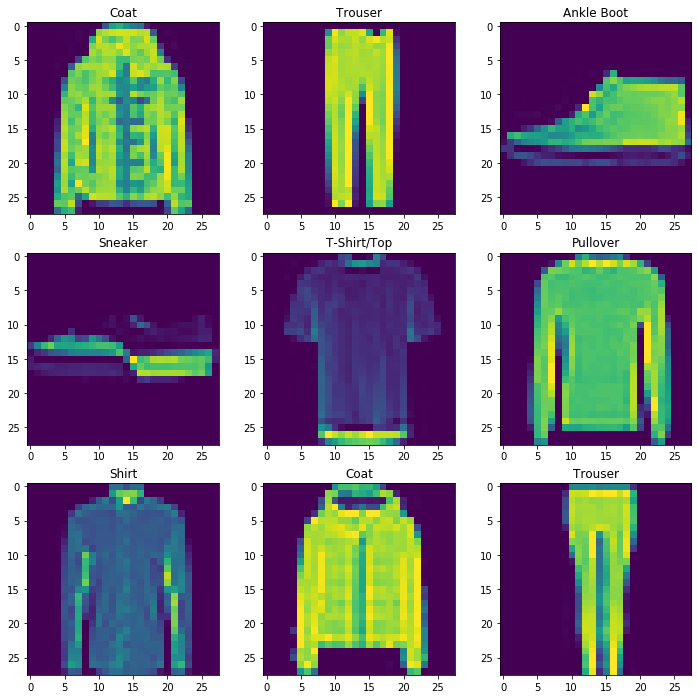

In [3]:
# Labels see Docu of Fashion-MNIST: 
# https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md

labels = ["T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle Boot"]
print("Plotting sample images")

plt.figure(figsize=(12,12))
for i in range(9):
    im_s = random.randrange(0, len(X_train),1)
    plt.subplot(3,3,1+i)
    plt.title(labels[y_train[im_s]])
    plt.imshow(X_train[im_s])    

## Set up Models for Discriminator, Generator and Combination

In [4]:
# Set Parameters

img_shape = (28, 28, 1) # Image Shape: 28x28x1 (Greyscale)
latent_dim = 100 #Input for Generator (Vector of Size 100)
optimizer = Adam(0.0002, 0.5)

In [5]:
# Generator Model
def build_generator(latent_dim, img_shape):
    latent_dim = latent_dim
    img_shape = img_shape
    
    model = Sequential()

    model.add(Dense(256, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))
    
    print("Summary of Generator Model:")
    model.summary()

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

In [6]:
# Discriminator Model
def build_discriminator(img_shape):

    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    
    print("Summary of Discriminator Model:")
    model.summary()

    img = Input(shape=img_shape)
    validity = model(img)

    return Model(img, validity)

In [7]:
# Build an compile all models

# Build and compile the discriminator
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
optimizer=optimizer,
metrics=['accuracy'])


# Build the generator
generator = build_generator(latent_dim, img_shape) 

# The generator takes noise as input and generates imgs
z = Input(shape=(latent_dim,)) # Initiates Tensor
img = generator(z)


# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
validity = discriminator(img)

# The combined model  (stacked generator and discriminator)
# Trains the generator to fool the discriminator
combined = Model(z, validity) 
#z = Tensor of size latent_dim, input for combined model
# validity = output of discrimintator, output of combined model

print("Summary of combined model: ")
combined.summary()
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

W1006 14:46:08.102474  4408 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1006 14:46:08.102474  4408 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1006 14:46:08.118110  4408 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1006 14:46:08.164988  4408 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1006 14:46:08.180604  4408 deprecation_

Summary of Discriminator Model:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 533,505
Trainable params: 533,505
Non-trainable params: 0
______________________________________

Generate Images with untrained Generator


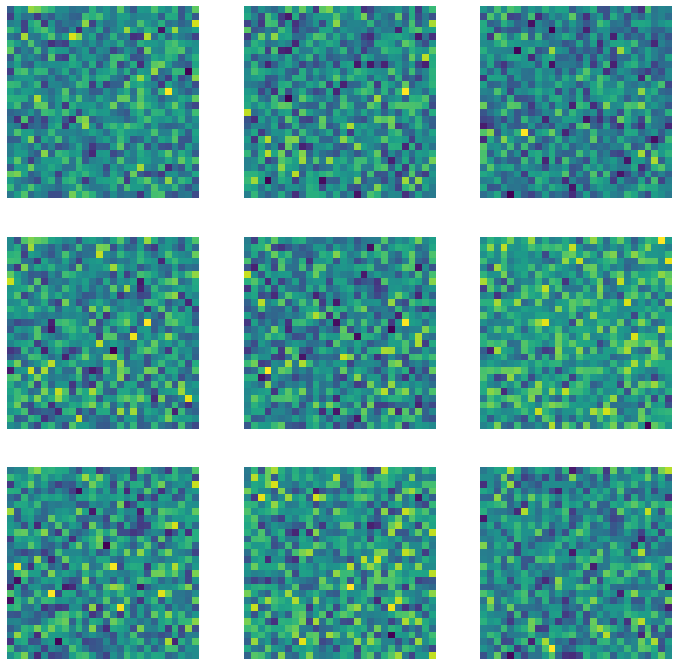

In [8]:
# Generate images
print("Generate Images with untrained Generator")
plt.figure(figsize=(12,12))
#Generate noise for 9 pictures
noise = np.random.normal(0, 1, (9, latent_dim))
img_new = generator.predict(noise)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis("off")
    plt.imshow(img_new[i,:,:,0]) 

## Training of Model

In [9]:
# Training of model

    
epochs = 6000
batch_size = 32
sample_interval=200
    


# Rescale dataset: -1 to 1
X_train = X_train / 127.5 - 1.

# Add additional Axis to X_train at third (last) place for batch
X_train = np.expand_dims(X_train, axis=3) 



# Adversarial ground truths
valid = np.ones((batch_size, 1))
fake = np.zeros((batch_size, 1))

sum_d_loss = []
sum_d_acc = []
sum_g_loss = []


for epoch in range(epochs):


    #  Train Discriminator
    
    # Select a random batch of images
    idx = np.random.randint(0, X_train.shape[0], batch_size)

    imgs = X_train[idx]
    
    # Noise: Input for Generator
    noise = np.random.normal(0, 1, (batch_size, latent_dim))


    # Generate a batch of new images
    gen_imgs = generator.predict(noise) #generates predicted images of batch size


    # train_on_batch: runs a singel gradient update on a singele batch. 
    d_loss_real = discriminator.train_on_batch(imgs, valid) #All real images are set as valid
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)  # All generated images are set as fake
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    

    

    #  Train Generator

    noise = np.random.normal(0, 1, (batch_size, latent_dim))

    # Train the generator (to have the discriminator label samples as valid)
    g_loss = combined.train_on_batch(noise, valid)

    # Progress
  
    sum_d_loss.append(d_loss[0])
    sum_d_acc.append(d_loss[1])
    sum_g_loss.append(g_loss)
    
    
    # Show progress
    if epoch % sample_interval == 0:
        print("Epochs: %d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))
       


C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epochs: 0 [D loss: 0.754425, acc.: 53.12%] [G loss: 0.731099]


C:\ProgramData\Anaconda3\envs\2019\lib\site-packages\keras\engine\training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epochs: 200 [D loss: 0.351275, acc.: 84.38%] [G loss: 3.601873]
Epochs: 400 [D loss: 0.630326, acc.: 68.75%] [G loss: 0.923250]
Epochs: 600 [D loss: 0.623442, acc.: 64.06%] [G loss: 0.975178]
Epochs: 800 [D loss: 0.632755, acc.: 65.62%] [G loss: 0.961826]
Epochs: 1000 [D loss: 0.612949, acc.: 59.38%] [G loss: 0.822117]
Epochs: 1200 [D loss: 0.601678, acc.: 64.06%] [G loss: 0.938298]
Epochs: 1400 [D loss: 0.659254, acc.: 57.81%] [G loss: 0.854784]
Epochs: 1600 [D loss: 0.626630, acc.: 67.19%] [G loss: 0.904037]
Epochs: 1800 [D loss: 0.646111, acc.: 62.50%] [G loss: 0.878299]
Epochs: 2000 [D loss: 0.578181, acc.: 68.75%] [G loss: 0.868430]
Epochs: 2200 [D loss: 0.617989, acc.: 65.62%] [G loss: 0.981514]
Epochs: 2400 [D loss: 0.703150, acc.: 51.56%] [G loss: 0.909058]
Epochs: 2600 [D loss: 0.667643, acc.: 54.69%] [G loss: 0.850327]
Epochs: 2800 [D loss: 0.585886, acc.: 76.56%] [G loss: 0.993119]
Epochs: 3000 [D loss: 0.672697, acc.: 56.25%] [G loss: 0.899538]
Epochs: 3200 [D loss: 0.66955

## Evaluation of model

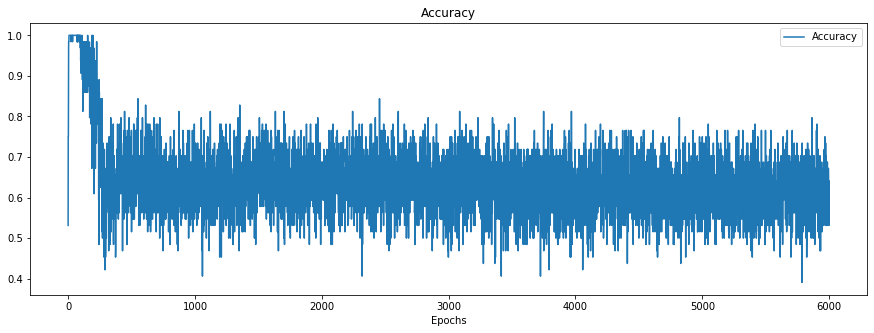

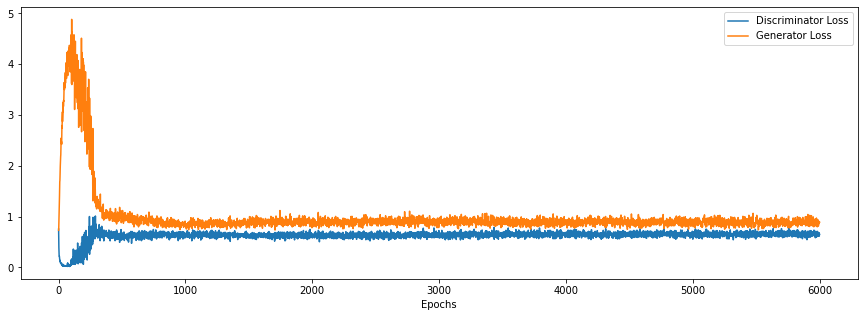

In [10]:
# Evaluate Model
plt.figure(figsize = (15,5))

plt.plot(sum_d_acc, label = "Accuracy")
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.legend()
plt.show()

plt.figure(figsize = (15,5))
plt.plot(sum_d_loss, label = "Discriminator Loss")
plt.plot(sum_g_loss, label = "Generator Loss")
plt.xlabel("Epochs")
plt.legend()
plt.show()

Generate Images with trained Generator after  6000  epochs


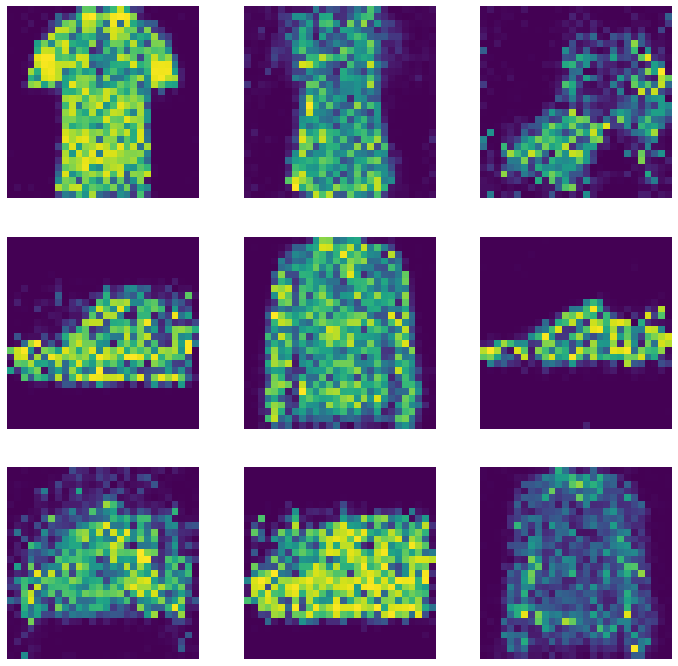

In [12]:
# Generate images
print("Generate Images with trained Generator after ", epochs, " epochs")
plt.figure(figsize=(12,12))

#Generate noise for 9 pictures
noise = np.random.normal(0, 1, (9, latent_dim))
img_new = generator.predict(noise)

for i in range(9):
    plt.subplot(3,3,1+i)
    plt.axis("off")
    plt.imshow(img_new[i,:,:,0]) 